## Noise Mitigation Using Richardson Extrapolation 
Mattias Fitzpatrick, Harshvardhan Babla, Shoumik Chowdhury, Ni-Ni Huang

The goal is to optimize the performance of NISQ devices by doing noise mitigation via the Richardson extrapolation technique.

To do this we will adapt the technique described in Kandala, et. al. arXiv:1805.04492, which stetches the length of the optimal gate set to intentionally introduce more errors to the system. 

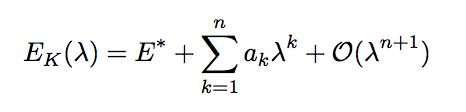

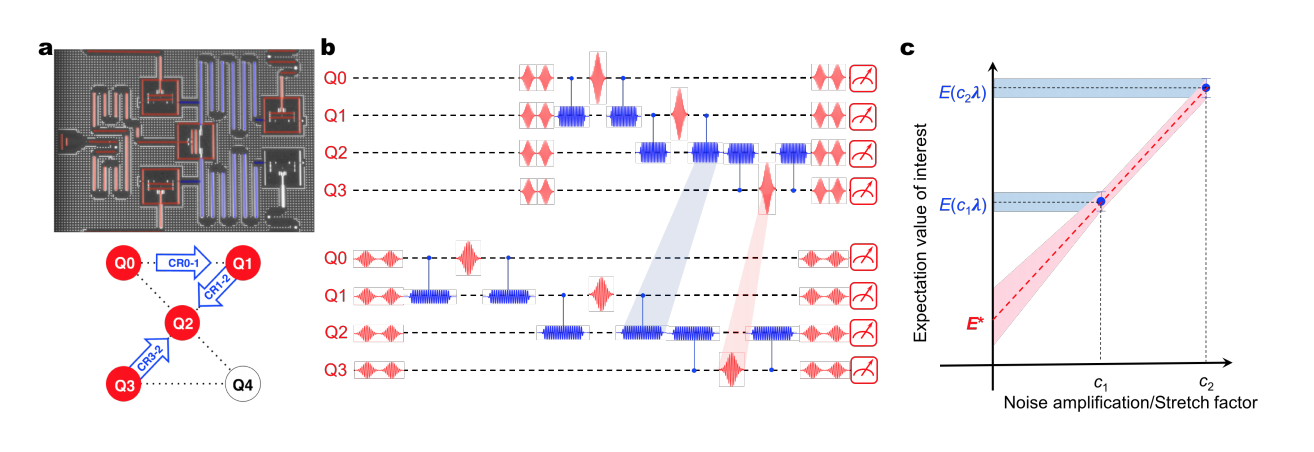

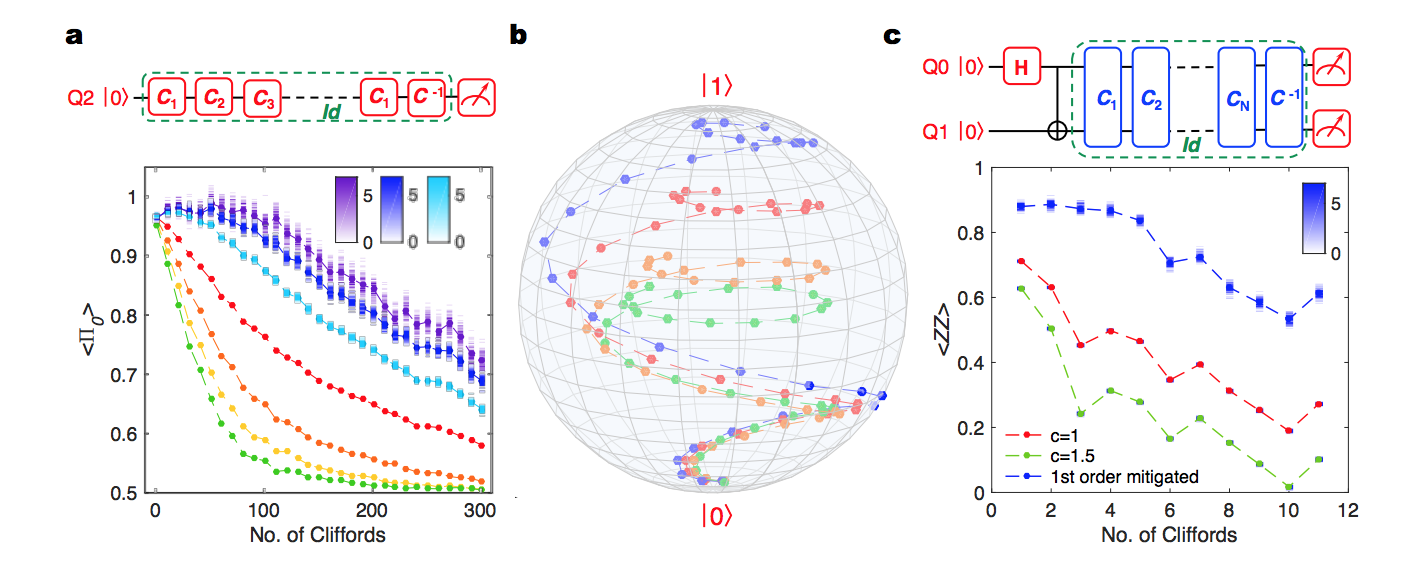

## Noisy Quantum Circuit

In [1]:
# Import Basics
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Import the noise model object
from qiskit.providers.aer.noise import NoiseModel

# Import all standard errors
from qiskit.providers.aer.noise.errors import *  

class NoisyQuantumCircuit(QuantumCircuit):
    
    def __init__(self, qReg, cReg, nQubits, errors1Qubit, errors2Qubit):
        super().__init__(qReg, cReg)
        self.createNoiseModel(nQubits, errors1Qubit, errors2Qubit)

    def createNoiseModel(self, nQubits, errors1Qubit, errors2Qubit):
        self.noiseModel = NoiseModel()
        for i in range(nQubits):
    
            for error in errors1Qubit:
                self.noiseModel.add_quantum_error(error, ['h'], [i])
                self.noiseModel.add_quantum_error(error, ['iden'], [i])
                self.noiseModel.add_quantum_error(error, ['rx'], [i])
                self.noiseModel.add_quantum_error(error, ['ry'], [i])
                self.noiseModel.add_quantum_error(error, ['rz'], [i])
                self.noiseModel.add_quantum_error(error, ['s'], [i])
                self.noiseModel.add_quantum_error(error, ['sdg'], [i])
                self.noiseModel.add_quantum_error(error, ['t'], [i])
                self.noiseModel.add_quantum_error(error, ['tdg'], [i])
                self.noiseModel.add_quantum_error(error, ['u0'], [i])
                self.noiseModel.add_quantum_error(error, ['u1'], [i])
                self.noiseModel.add_quantum_error(error, ['u2'], [i])
                self.noiseModel.add_quantum_error(error, ['u3'], [i])
                self.noiseModel.add_quantum_error(error, ['x'], [i])
                self.noiseModel.add_quantum_error(error, ['y'], [i])
                self.noiseModel.add_quantum_error(error, ['z'], [i])

            for error in errors2Qubit:
                for j in range(nQubits):
                    self.noiseModel.add_quantum_error(error, ['cx'], [i,j])
                    self.noiseModel.add_quantum_error(error, ['cy'], [i,j])
                    self.noiseModel.add_quantum_error(error, ['cz'], [i,j])
                    self.noiseModel.add_quantum_error(error, ['ch'], [i,j])
                    self.noiseModel.add_quantum_error(error, ['crz'], [i,j])
                    self.noiseModel.add_quantum_error(error, ['cu1'], [i,j])
                    self.noiseModel.add_quantum_error(error, ['cu3'], [i,j])
                    self.noiseModel.add_quantum_error(error, ['swap'], [i,j])
                

    def getNoiseModel(self):
        return self.noiseModel

In [ ]:
nPoints = 20
stretchFactors = [1, 1.25, 2, 3, 4, 5]
gatePairCounts = [x*10 for x in range(nPoints)]
yAggregator = []
numShots = 4096

for sf in stretchFactors:
    y = []
    
    for gpc in gatePairCounts:
        
        # Thermal Relaxation Error - T1
        T1 = 12000  # nanoseconds
        T2 = T1 * 2 # nanoseconds
        Tau0 = 50   # nanoseconds
        pulseWidth = sf * Tau0 
        
        thermalError1bit = thermal_relaxation_error(T1, T2, pulseWidth)
        thermalError2bit = thermal_relaxation_error(T1, T2, pulseWidth).kron(
                            thermal_relaxation_error(T1, T2, pulseWidth))
        
        counts = CompileAndSimulate(gatePairCount = gpc, nQubits = 1, bitIdx = 0, numShots = numShots,
                                    errors1Qubit = [thermalError1bit], errors2Qubit = [thermalError2bit])
        
        if(counts["0"] == None): 
            p = 0
        else:
            p = counts["0"]/numShots
            
        y.append(p)
    
    yAggregator.append(y)
    plt.plot(gatePairCounts, y, label="stretch factor = {0}".format(sf))

plt.legend()
plt.show()

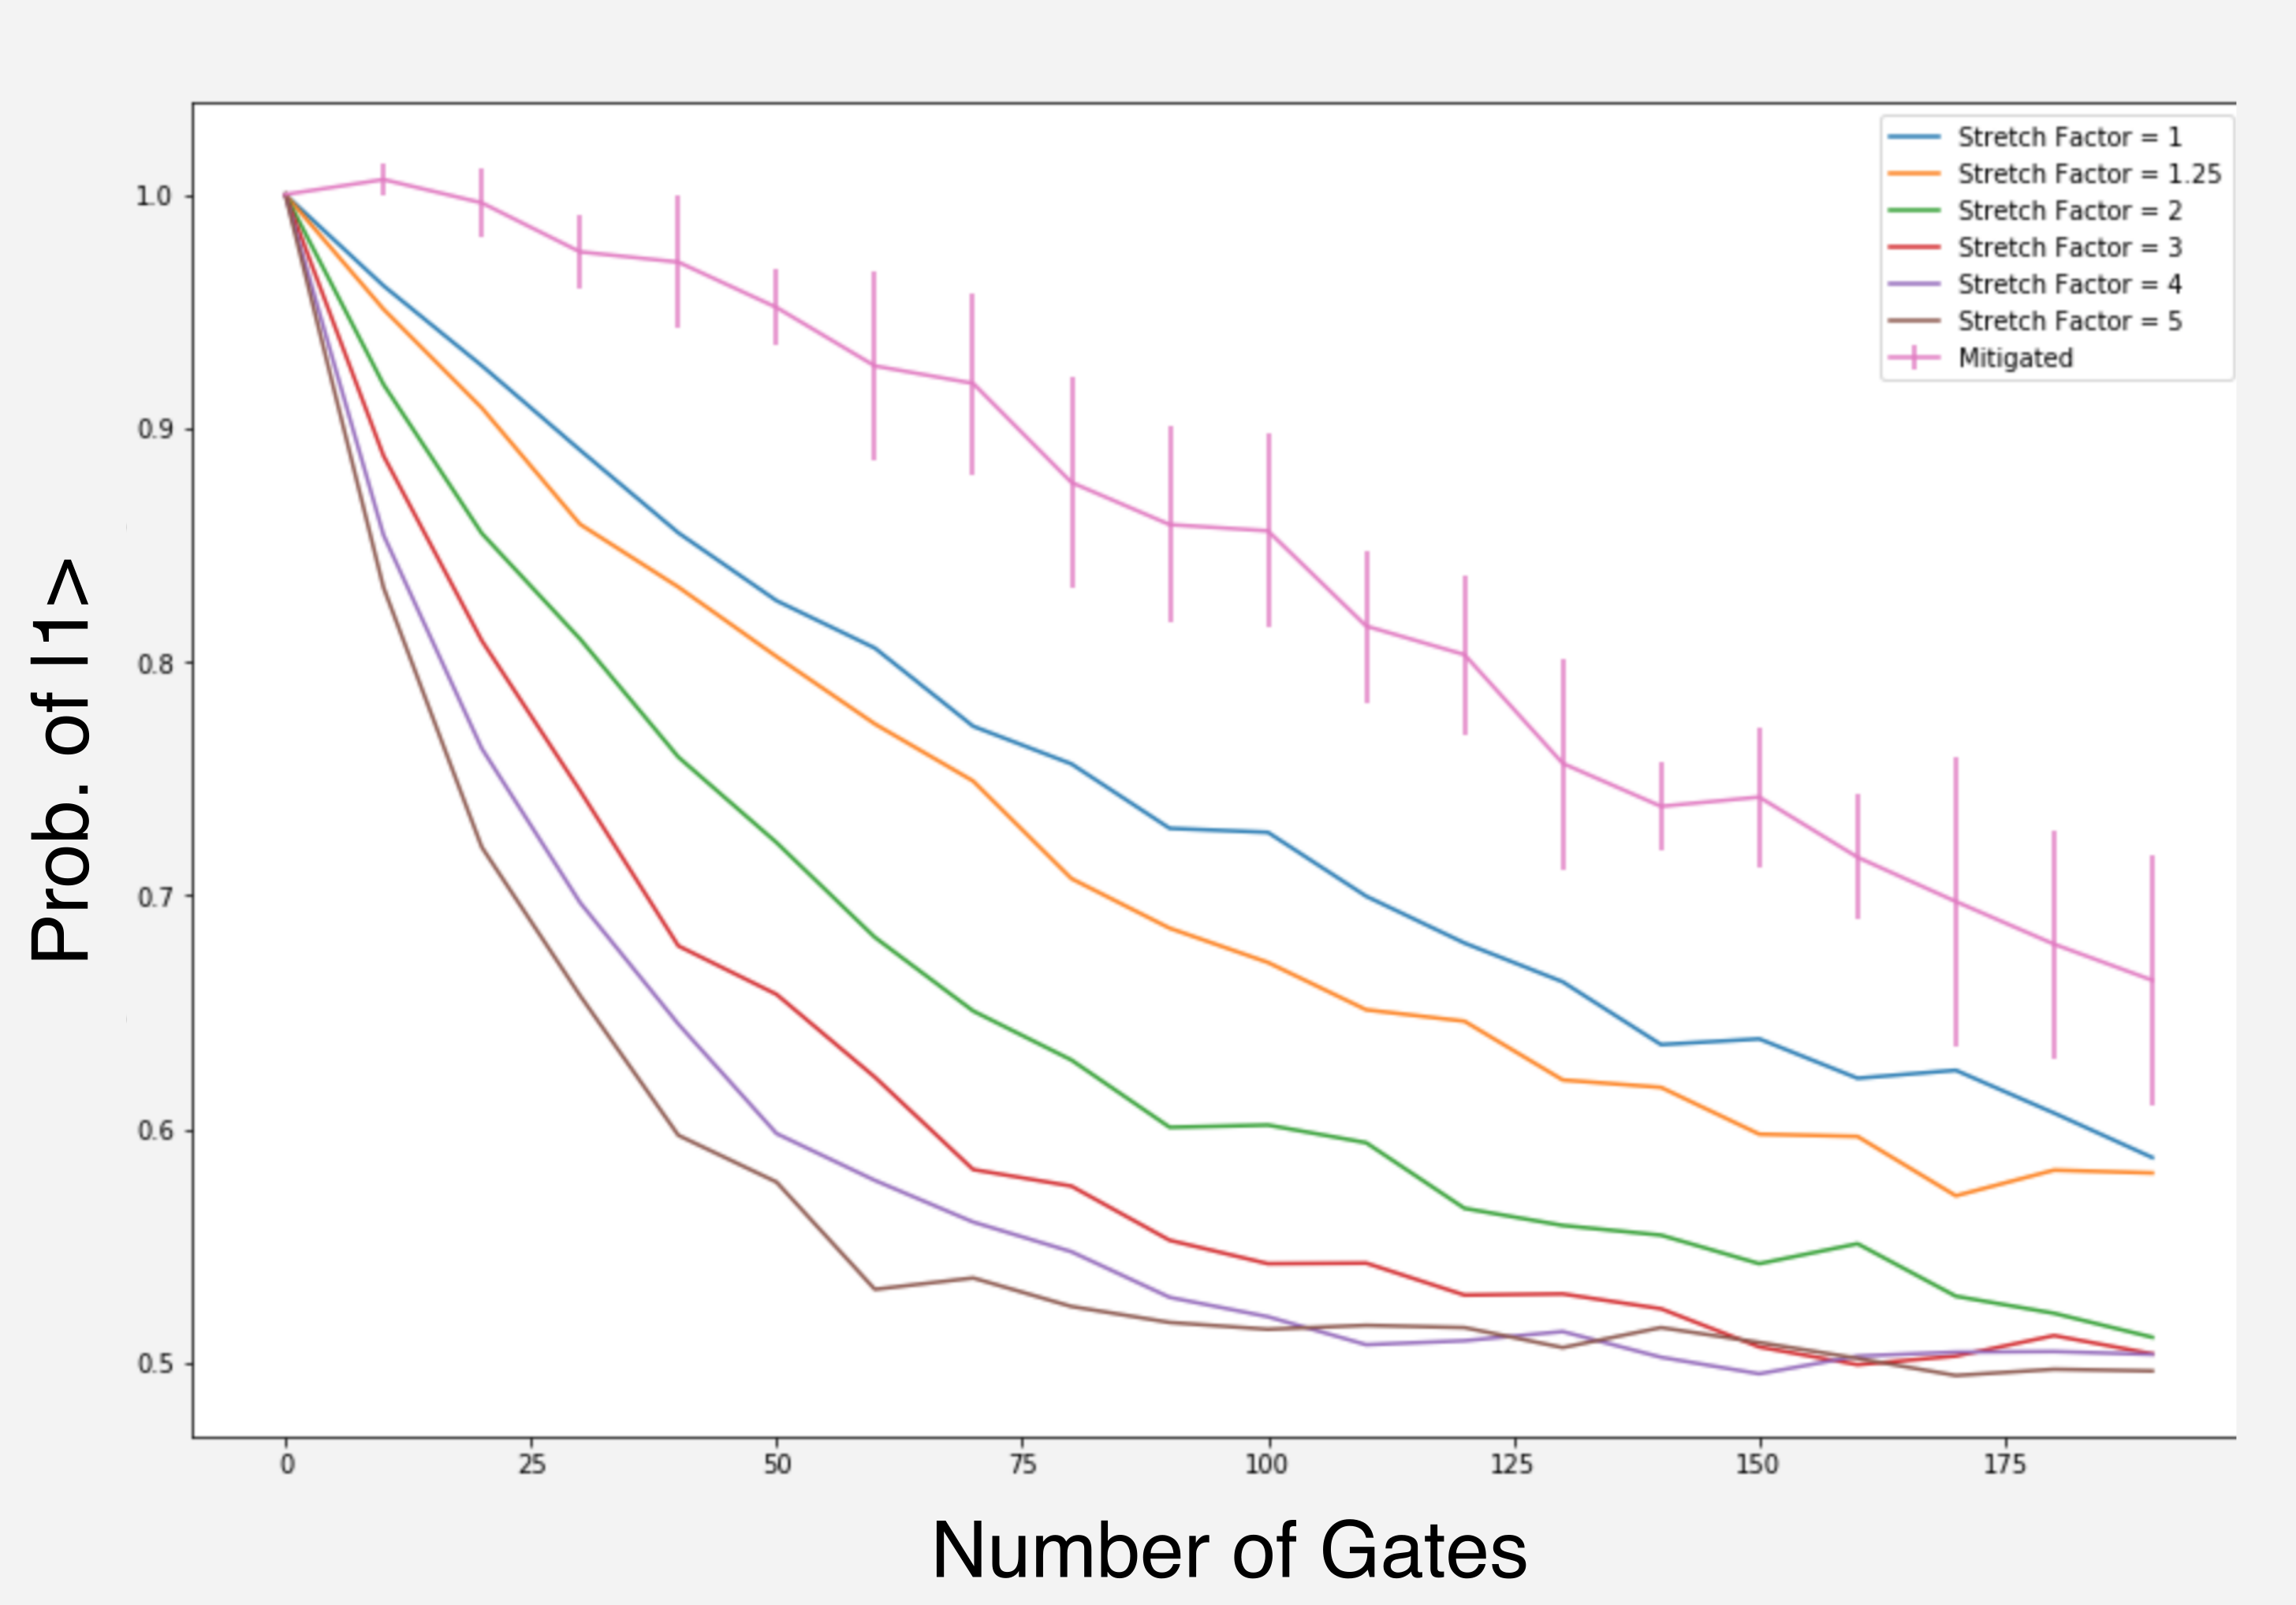

In [ ]:
T1 = 12000  # nanoseconds
T2 = T1 * 2 # nanoseconds
Tau0 = 50   # nanoseconds    
pulseWidth = 1.25*Tau0

thermalError1bit = thermal_relaxation_error(T1, T2, pulseWidth)
thermalError2bit = thermal_relaxation_error(T1, T2, pulseWidth).kron(
                    thermal_relaxation_error(T1, T2, pulseWidth))


return_list = CompileAndTeleport(debug = True, 
                            errors1Qubit = [thermalError1bit], errors2Qubit = [thermalError2bit])
counts = return_list[0]
mag_a0 = return_list[1]
mag_b0 = return_list[2]

print(counts)
qplt.plot_histogram(counts)

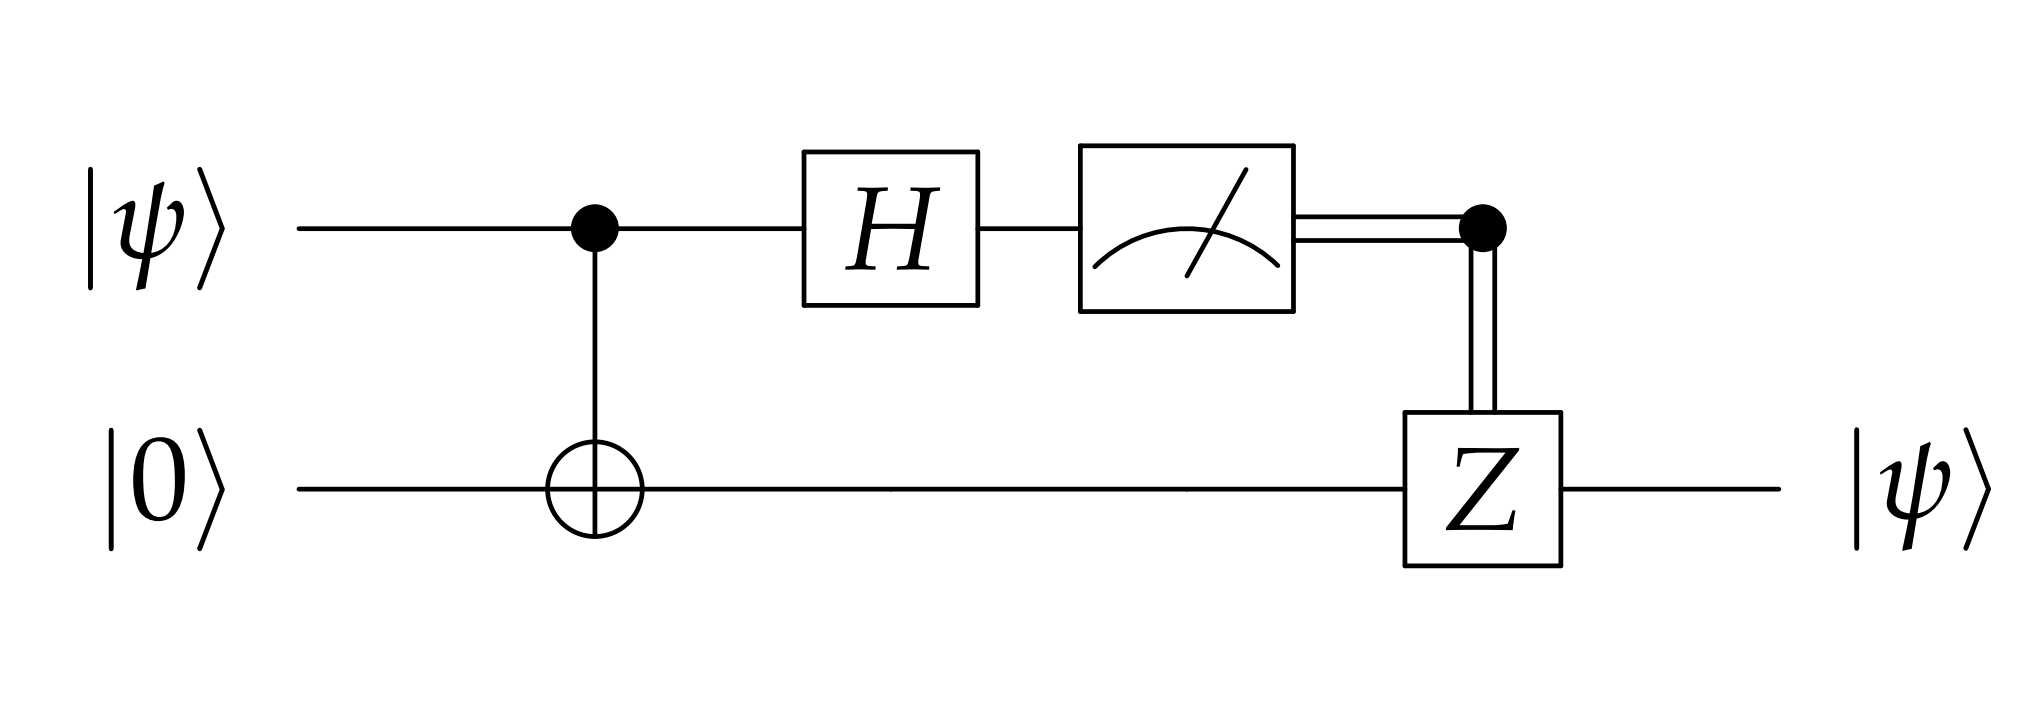

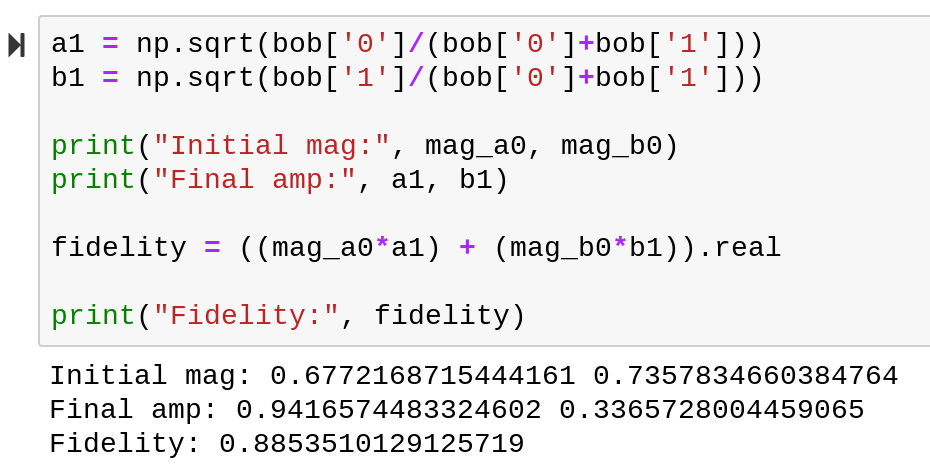

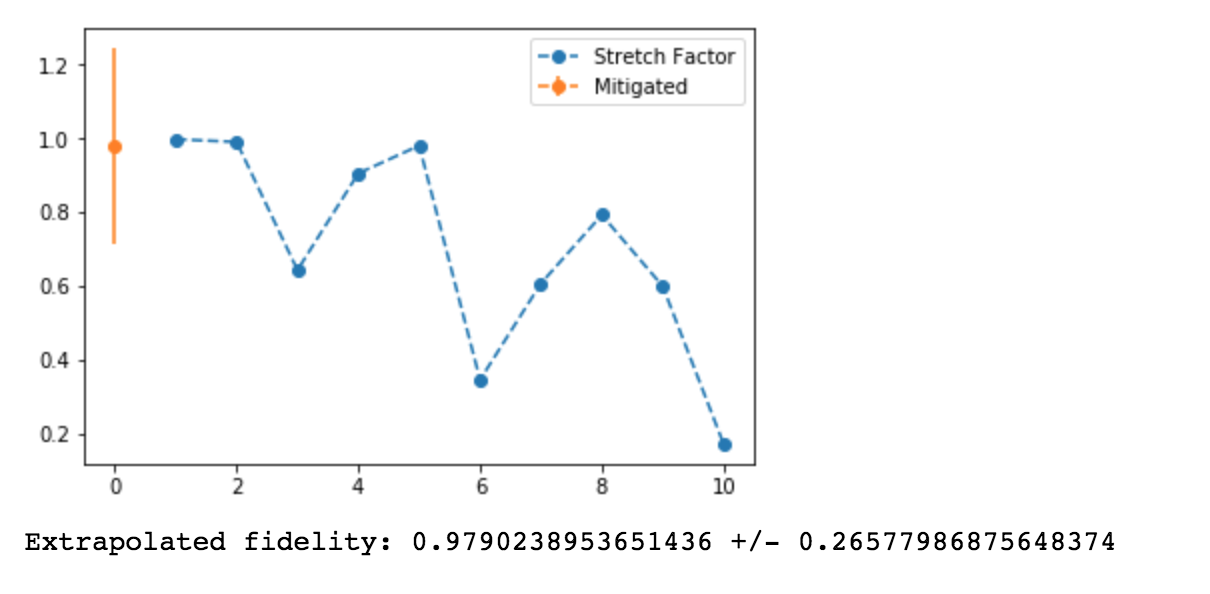

## Quantum Chemistry with Noise

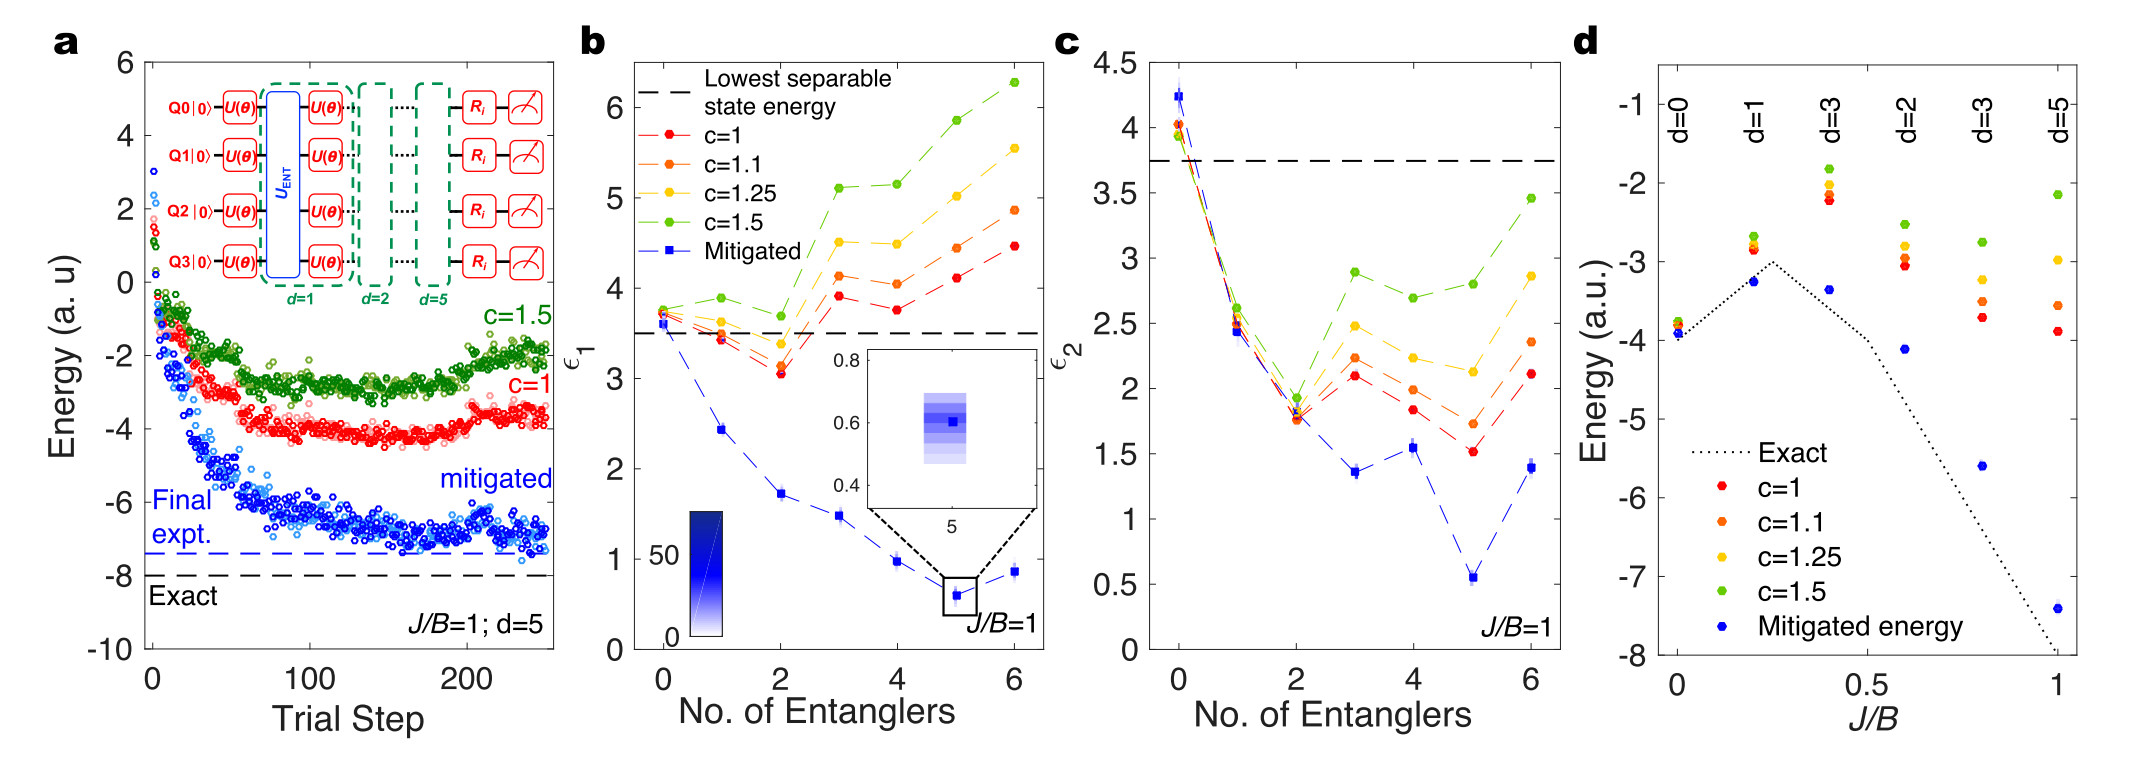

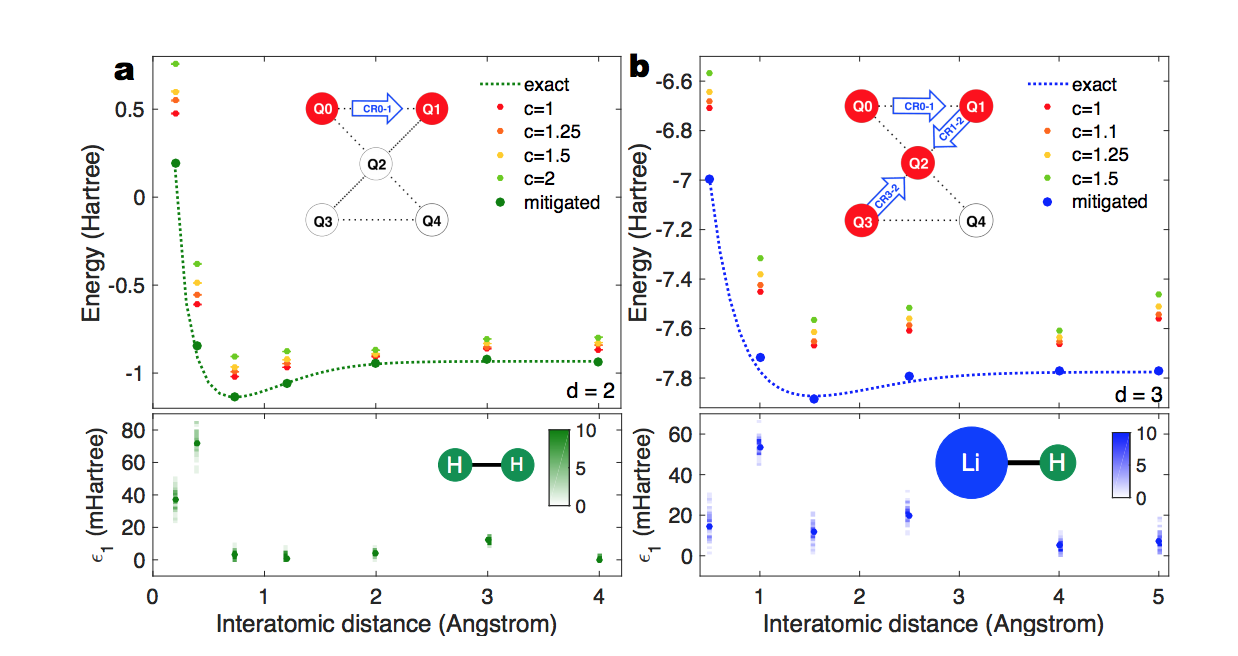

In [ ]:
import numpy as np
import matplotlib as mpl
from collections import OrderedDict
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
# Import the noise model object
from qiskit.providers.aer.noise import NoiseModel

# Import all standard errors
from qiskit.providers.aer.noise.errors import *  

# Import noise base clases
from qiskit.providers.aer.noise.errors.quantum_error import QuantumError
from qiskit.providers.aer.noise.errors.readout_error import ReadoutError
# import NoisyQuantumCircuit as NoisyQuantumCircuit

# Use PySCF, a classical computational chemistry software package, to compute the one- and
# two-body integrals in molecular-orbital basis, necessary to form the Fermionic operator
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.735', unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
molecule = driver.run()
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

# Build the qubit operator, which is the input to the VQE algorithm in Aqua
ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
map_type = 'PARITY'
qubitOp = ferOp.mapping(map_type)
qubitOp = qubitOp.two_qubit_reduced_operator(num_particles)
num_qubits = qubitOp.num_qubits

# set the backend for the quantum computation
from qiskit import Aer
# backend = Aer.get_backend('statevector_simulator')
backend = Aer.get_backend('qasm_simulator')

# setup a classical optimizer for VQE
from qiskit.aqua.components.optimizers import L_BFGS_B
optimizer = L_BFGS_B()

# setup the initial state for the variational form
from qiskit.chemistry.aqua_extensions.components.initial_states import HartreeFock
init_state = HartreeFock(num_qubits, num_spin_orbitals, num_particles)

# setup the variational form for VQE
from qiskit.aqua.components.variational_forms import RYRZ
var_form = RYRZ(num_qubits, initial_state=init_state)


T1Vec = np.linspace(200000,20000,10)
eigValVec = np.zeros((len(T1Vec),))
for idx in range(len(T1Vec)):
    # T1 = 12000  # nanoseconds
    T1 = T1Vec[idx]
    T2 = T1 * 2 # nanoseconds
    Tau0 = 50   # nanoseconds    
    pulseWidth = 1.25*Tau0

    errors1Qubit = thermal_relaxation_error(T1, T2, pulseWidth)
    errors2Qubit = thermal_relaxation_error(T1, T2, pulseWidth).kron(
                    thermal_relaxation_error(T1, T2, pulseWidth))


    # setup and run VQE
    from qiskit.aqua.algorithms import VQE
    algorithm = VQE(qubitOp, var_form, optimizer, [errors1Qubit],[errors2Qubit])
    # algorithm.print_setting
    # print(qubitOp,algorithm.solve())

    # algorithm.construct
    # print(algorithm)

    result = algorithm.run(backend)
    eigValVec[idx] = result['eigvals'][0]
    print(eigValVec[idx])